# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is an example of this project using Sagemaker and AutoGluon.

## Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [1]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [2]:
# create the .kaggle directory and an empty kaggle.json file
# !mkdir -p /root/.kaggle
# !touch /root/.kaggle/kaggle.json
# !chmod 600 /root/.kaggle/kaggle.json

In [3]:
# Fill in your user name and key from creating the kaggle account and API token file
# import json
# kaggle_username = "FILL_IN_USERNAME"
# kaggle_key = "FILL_IN_KEY"

# Save API token the kaggle.json file
# with open("/root/.kaggle/kaggle.json", "w") as f:
#     f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms
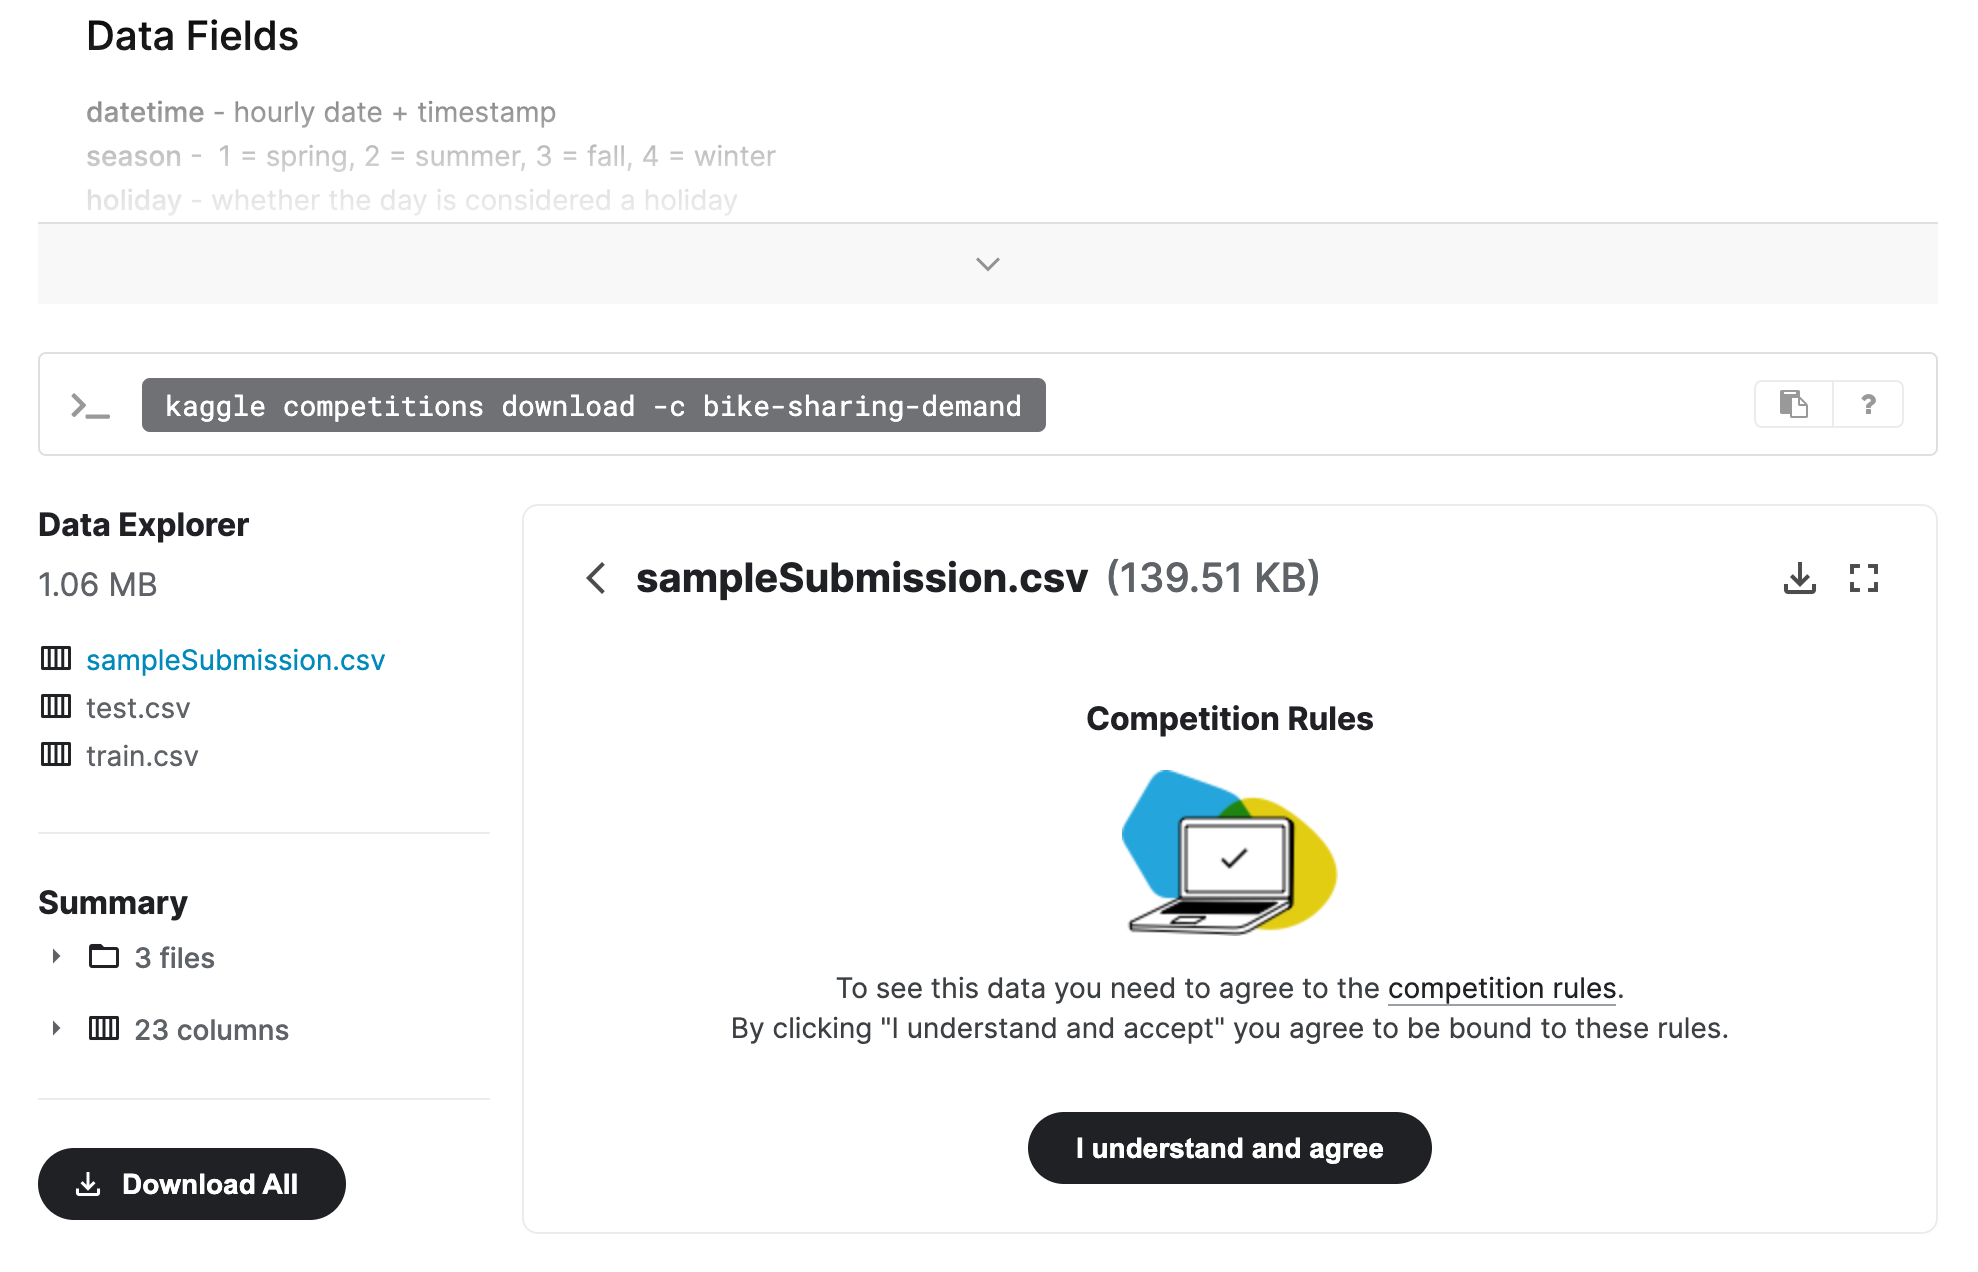

In [4]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from autogluon.tabular import TabularPredictor

params = {'legend.fontsize':'x-large',  
          'figure.figsize':(16,13),
          'axes.labelsize':'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

/home/malanistamez/Documentos/MLE_projects/.env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv', parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [9]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv', parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [10]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv')
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [11]:
predictor = TabularPredictor(label='count', problem_type='regression', eval_metric='root_mean_squared_error',
learner_kwargs={'ignored_columns': ['casual', 'registered']}).fit(train_data=train, time_limit=600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20221229_014313/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20221229_014313/"
AutoGluon Version:  0.6.1
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #136-Ubuntu SMP Fri Jun 10 13:40:48 UTC 2022
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    420.48 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the 

### Review AutoGluon's training run with ranking of models that did the best.

In [12]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -51.283501       4.029218  285.804801                0.001405           0.634303            3       True         13
1   NeuralNetFastAI_BAG_L2  -52.791021       2.987238  273.472861                1.218245         132.825160            2       True         12
2     ExtraTreesMSE_BAG_L2  -53.156471       2.410035  145.951696                0.641041           5.303994            2       True         11
3   RandomForestMSE_BAG_L2  -53.593468       2.168527  147.041344                0.399534           6.393642            2       True          9
4          CatBoost_BAG_L2  -55.238987       1.866548  189.763898                0.097554          49.116197            2       True         10
5    KNeighborsDist_BAG_L1  -84.125061       0.038706    0.059563         

/home/malanistamez/Documentos/MLE_projects/.env/lib/python3.8/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -178.751832961977,
  'LightGBM_BAG_L1': -177.94493629824913,
  'RandomForestMSE_BAG_L1': -116.54835939455667,
  'WeightedEnsemble_L2': -84.12506123181

### Create predictions from test dataset

In [13]:
predictions = predictor.predict(test)
predictions.head()

0    24.681427
1    39.220367
2    43.465340
3    44.858902
4    47.820488
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [14]:
# Describe the `predictions` series to see if there are any negative values
(predictions<0)

0       False
1       False
2       False
3       False
4       False
        ...  
6488    False
6489    False
6490    False
6491    False
6492    False
Name: count, Length: 6493, dtype: bool

In [15]:
# How many negative values do we have?
(predictions<0).sum()

1

In [16]:
# Set them to zero

def set_to_zero(value):
    if value<0:
        return 0
    else:
        return value

predictions = predictions.map(set_to_zero)

### Set predictions to submission dataframe, save, and submit

In [17]:
submission["count"] = predictions.values
submission.to_csv("submission.csv", index=False)

In [18]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 243k/243k [00:01<00:00, 126kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [19]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2022-12-29 01:55:08  first raw submission               complete  1.82358      1.82358       
submission_new_features.csv  2022-12-27 21:38:35  new features                       complete  0.98987      0.98987       
submission.csv               2022-12-27 21:23:14  first raw submission               complete  1.79747      1.79747       


#### Initial score of `1.82358`

## Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<AxesSubplot: title={'center': 'datetime'}>,
        <AxesSubplot: title={'center': 'season'}>,
        <AxesSubplot: title={'center': 'holiday'}>],
       [<AxesSubplot: title={'center': 'workingday'}>,
        <AxesSubplot: title={'center': 'weather'}>,
        <AxesSubplot: title={'center': 'temp'}>],
       [<AxesSubplot: title={'center': 'atemp'}>,
        <AxesSubplot: title={'center': 'humidity'}>,
        <AxesSubplot: title={'center': 'windspeed'}>],
       [<AxesSubplot: title={'center': 'casual'}>,
        <AxesSubplot: title={'center': 'registered'}>,
        <AxesSubplot: title={'center': 'count'}>]], dtype=object)

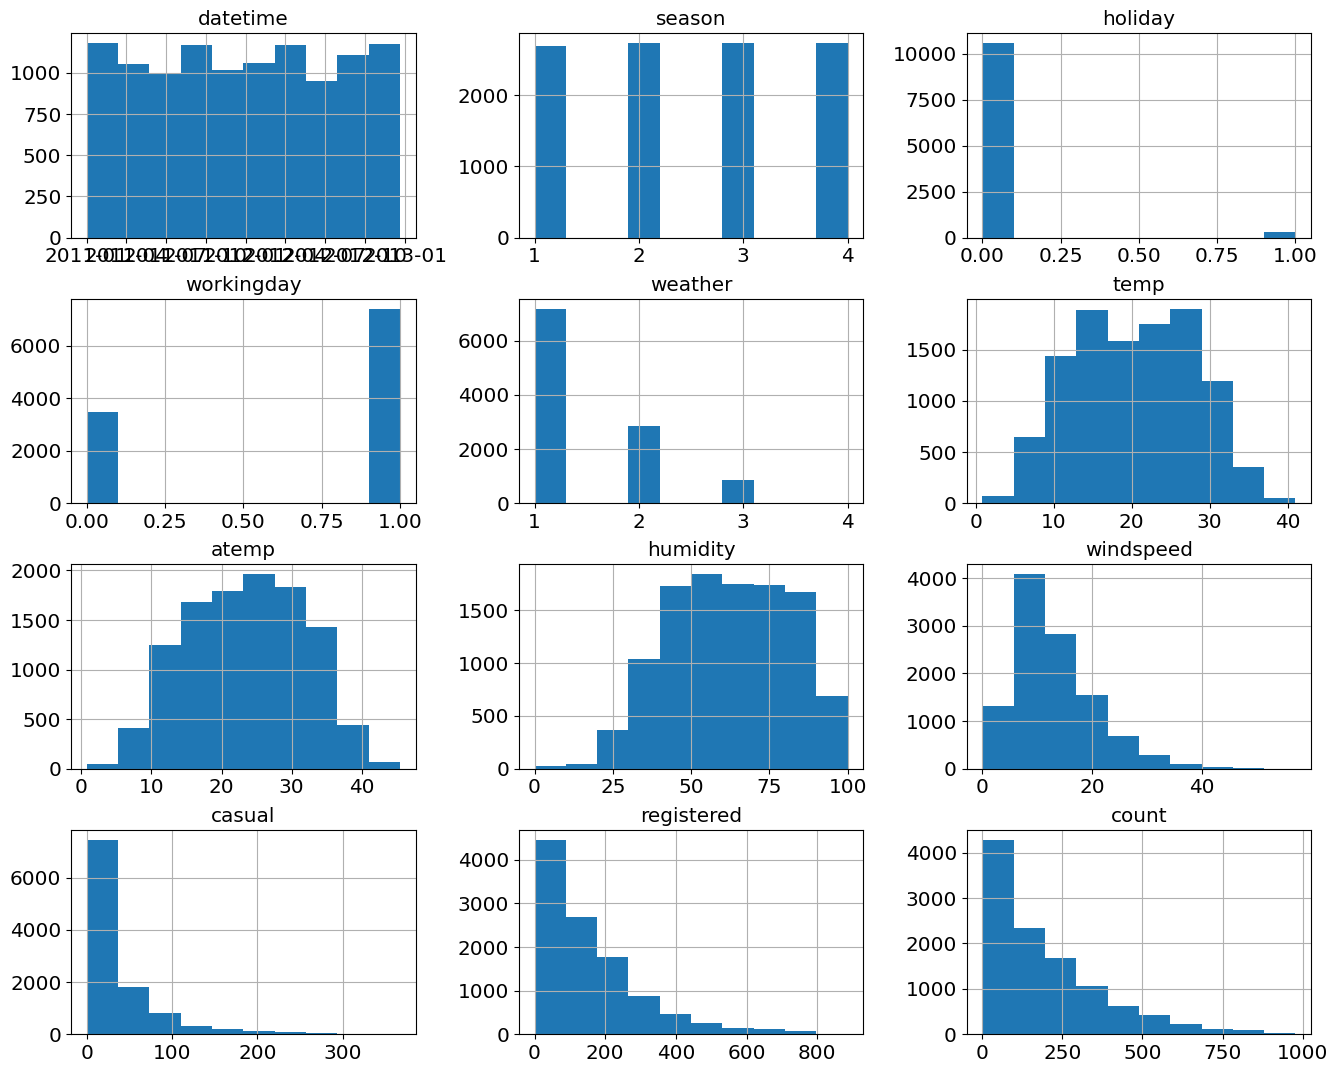

In [20]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist()

In [21]:
# create a new feature
def create_time_features(df):
    L = ['month', 'day', 'hour', 'dayofweek']

    date_gen = (getattr(df['datetime'].dt, i).rename(i) for i in L)
    df = df.join(pd.concat(date_gen, axis=1))

    return df

train = create_time_features(train)
test = create_time_features(test)

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [22]:
train[['season','weather']] = train[['season','weather']].astype('category')
test[['season','weather']] = test[['season','weather']].astype('category')

In [23]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,1,4,5


array([[<AxesSubplot: title={'center': 'datetime'}>,
        <AxesSubplot: title={'center': 'holiday'}>,
        <AxesSubplot: title={'center': 'workingday'}>,
        <AxesSubplot: title={'center': 'temp'}>],
       [<AxesSubplot: title={'center': 'atemp'}>,
        <AxesSubplot: title={'center': 'humidity'}>,
        <AxesSubplot: title={'center': 'windspeed'}>,
        <AxesSubplot: title={'center': 'casual'}>],
       [<AxesSubplot: title={'center': 'registered'}>,
        <AxesSubplot: title={'center': 'count'}>,
        <AxesSubplot: title={'center': 'month'}>,
        <AxesSubplot: title={'center': 'day'}>],
       [<AxesSubplot: title={'center': 'hour'}>,
        <AxesSubplot: title={'center': 'dayofweek'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

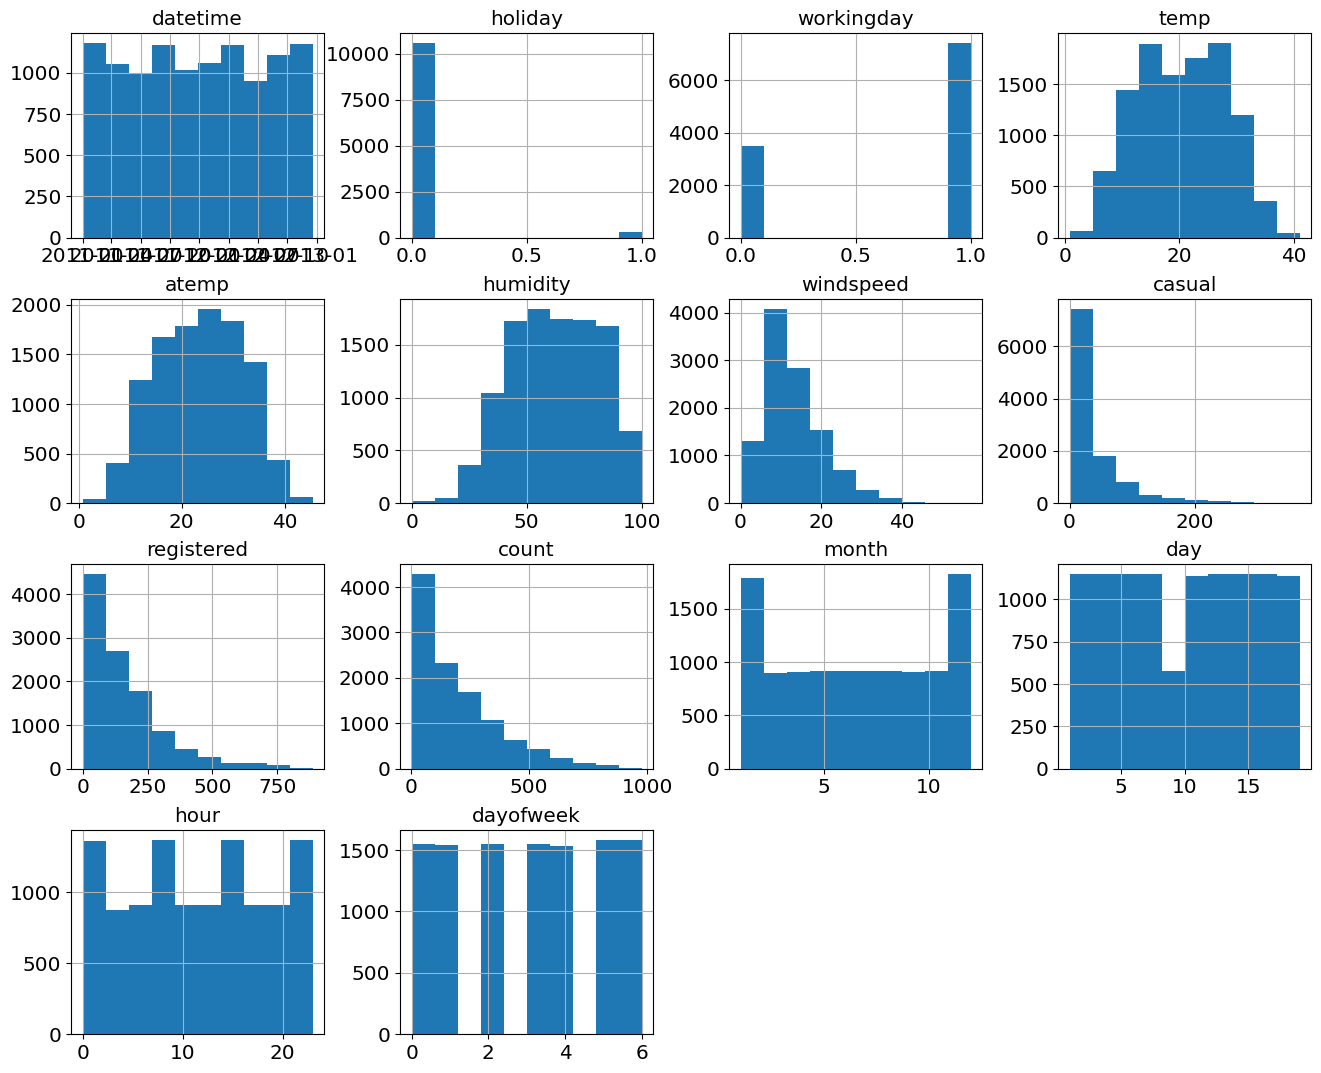

In [24]:
# View histogram of all features again now with the hour feature
train.hist()

## Rerun the model with the same settings as before, just with more features

In [25]:
predictor_new_features = TabularPredictor(label='count', problem_type='regression', eval_metric='root_mean_squared_error',
learner_kwargs={'ignored_columns': ['casual', 'registered']}).fit(train_data=train, time_limit=600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20221229_015520/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20221229_015520/"
AutoGluon Version:  0.6.1
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #136-Ubuntu SMP Fri Jun 10 13:40:48 UTC 2022
Train Data Rows:    10886
Train Data Columns: 15
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    821.06 MB
	Train Data (Original)  Memory Usage: 0.98 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the 

In [26]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                    model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L2  -33.155646       5.008877  885.892197                0.001977           1.883696            2       True          7
1         CatBoost_BAG_L1  -33.829628       4.632558  877.937875                4.632558         877.937875            1       True          6
2  RandomForestMSE_BAG_L1  -38.565776       0.330516    6.014804                0.330516           6.014804            1       True          5
3   KNeighborsDist_BAG_L1  -84.125061       0.043826    0.055822                0.043826           0.055822            1       True          2
4   KNeighborsUnif_BAG_L1 -101.546199       0.051330    0.097607                0.051330           0.097607            1       True          1
5         LightGBM_BAG_L1 -173.818077       0.157904   52.388517                

/home/malanistamez/Documentos/MLE_projects/.env/lib/python3.8/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -176.19953427579537,
  'LightGBM_BAG_L1': -173.81807710181408,
  'RandomForestMSE_BAG_L1': -38.56577584768158,
  'CatBoost_BAG_L1': -33.829628023216124,
  'WeightedEnsemble_L2': -33.15564584201034},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif_BAG_L1': 'AutogluonModels/ag-20221229_015520/models/KNeighborsUnif_BAG_L1/',
  'KNeighborsDist_BAG_L1': 'AutogluonModels/ag-20221229_015520/models/KNeighborsDist_BAG_L1/',
  'LightGBMXT_BAG_L1': 'AutogluonM

In [27]:
# Remember to set all negative values to zero
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features = predictions_new_features.map(set_to_zero)

In [28]:
# Same submitting predictions
submission_new_features = submission.copy()
submission_new_features["count"] = predictions_new_features.values
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [29]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 241k/241k [00:02<00:00, 118kB/s]
Successfully submitted to Bike Sharing Demand

In [30]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2022-12-29 02:14:29  new features                       complete  0.56122      0.56122       
submission.csv               2022-12-29 01:55:08  first raw submission               complete  1.82358      1.82358       
submission_new_features.csv  2022-12-27 21:38:35  new features                       complete  0.98987      0.98987       


#### New Score of `0.56122`

## Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [39]:
from autogluon.core.space import Categorical, Int, Real

custom_hyperparameters_hpo = {"RF": {
    'max_depth': Int(lower=3, upper=30),
    'max_features': Real(lower=0.1, upper=1.0),
    'max_samples': Real(lower=0.1, upper=1.0)
}}

predictor_new_hpo = TabularPredictor(label='count', problem_type='regression', eval_metric='root_mean_squared_error',
learner_kwargs={'ignored_columns': ['casual', 'registered']}).fit(train_data=train, hyperparameters=custom_hyperparameters_hpo,
hyperparameter_tune_kwargs='auto', time_limit=600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20221229_030258/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20221229_030258/"
AutoGluon Version:  0.6.1
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #136-Ubuntu SMP Fri Jun 10 13:40:48 UTC 2022
Train Data Rows:    10886
Train Data Columns: 15
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    362.7 MB
	Train Data (Original)  Memory Usage: 0.98 MB (0.3% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the f

In [40]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                        model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         WeightedEnsemble_L3  -35.873764       0.038174  465.723674                0.000865           0.364259            3       True        136
1      RandomForest_BAG_L2/T4  -35.910193       0.036833  379.157550                0.000261          27.295662            2       True        134
2      RandomForest_BAG_L2/T3  -36.041327       0.036738  385.096692                0.000167          33.234803            2       True        133
3      RandomForest_BAG_L2/T5  -36.050258       0.036881  404.828950                0.000310          52.967062            2       True        135
4      RandomForest_BAG_L2/T2  -36.185347       0.036870  424.873649                0.000298          73.011760            2       True        132
5         WeightedEnsemble_L2  -37.016080       0.003412

/home/malanistamez/Documentos/MLE_projects/.env/lib/python3.8/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'RandomForest_BAG_L1/T1': 'StackerEnsembleModel_RF',
  'RandomForest_BAG_L1/T2': 'StackerEnsembleModel_RF',
  'RandomForest_BAG_L1/T3': 'StackerEnsembleModel_RF',
  'RandomForest_BAG_L1/T4': 'StackerEnsembleModel_RF',
  'RandomForest_BAG_L1/T5': 'StackerEnsembleModel_RF',
  'RandomForest_BAG_L1/T6': 'StackerEnsembleModel_RF',
  'RandomForest_BAG_L1/T7': 'StackerEnsembleModel_RF',
  'RandomForest_BAG_L1/T8': 'StackerEnsembleModel_RF',
  'RandomForest_BAG_L1/T9': 'StackerEnsembleModel_RF',
  'RandomForest_BAG_L1/T10': 'StackerEnsembleModel_RF',
  'RandomForest_BAG_L1/T11': 'StackerEnsembleModel_RF',
  'RandomForest_BAG_L1/T12': 'StackerEnsembleModel_RF',
  'RandomForest_BAG_L1/T13': 'StackerEnsembleModel_RF',
  'RandomForest_BAG_L1/T14': 'StackerEnsembleModel_RF',
  'RandomForest_BAG_L1/T15': 'StackerEnsembleModel_RF',
  'RandomForest_BAG_L1/T16': 'StackerEnsembleModel_RF',
  'RandomForest_BAG_L1/T17': 'StackerEnsembleModel_RF',
  'RandomForest_BAG_L1/T18': 'StackerEnsem

In [41]:
# Remember to set all negative values to zero
predictions_new_hpo = predictor_new_hpo.predict(test)
predictions_new_hpo = predictions_new_hpo.map(set_to_zero)

In [42]:
# Same submitting predictions

submission_new_hpo = submission.copy()
submission_new_hpo["count"] = predictions_new_hpo.values 
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [43]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 242k/242k [00:02<00:00, 107kB/s]
Successfully submitted to Bike Sharing Demand

In [44]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2022-12-29 03:14:18  new features with hyperparameters  complete  0.49164      0.49164       
submission_new_features.csv  2022-12-29 02:14:29  new features                       complete  0.56122      0.56122       
submission.csv               2022-12-29 01:55:08  first raw submission               complete  1.82358      1.82358       


#### New Score of `0.49164`

## Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

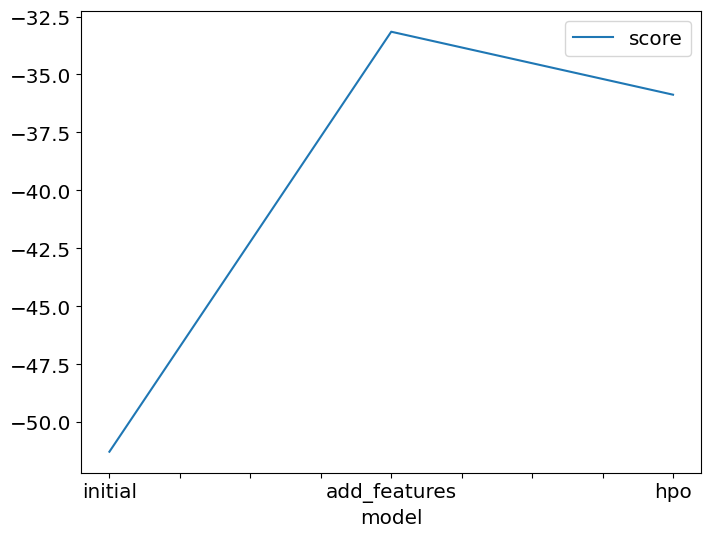

In [45]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [predictor.leaderboard(silent=True)['score_val'][0],
          predictor_new_features.leaderboard(silent=True)['score_val'][0],
          predictor_new_hpo.leaderboard(silent=True)['score_val'][0]]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('img/model_train_score.png')

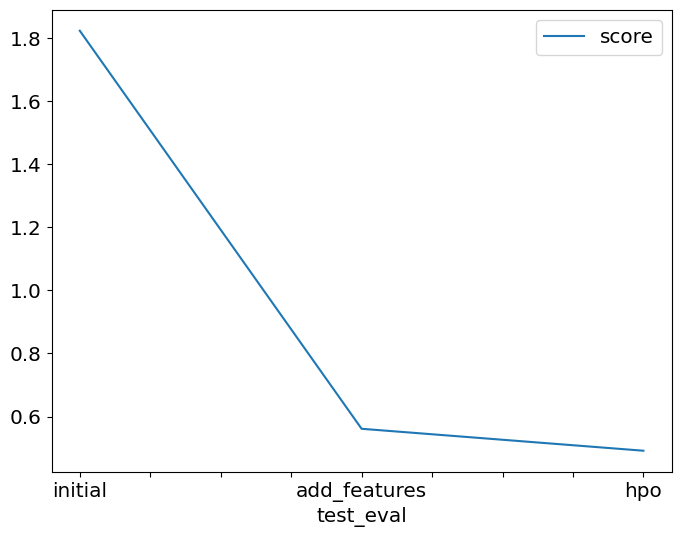

In [60]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.82358, 0.56122, 0.49164]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('img/model_test_score.png')

### Hyperparameter table

In [54]:
leaderboard_hpo = predictor_new_hpo.leaderboard(silent=True)
best_model_name = leaderboard_hpo[leaderboard_hpo['stack_level'] == 1]['model'].iloc[0]

predictor_info = predictor_new_hpo.info()
best_model_info = predictor_info['model_info'][best_model_name]

In [57]:
print(best_model_info)

{'name': 'RandomForest_BAG_L1/T101', 'model_type': 'StackerEnsembleModel', 'problem_type': 'regression', 'eval_metric': 'root_mean_squared_error', 'stopping_metric': 'root_mean_squared_error', 'fit_time': 3.4434194564819336, 'num_classes': None, 'quantile_levels': None, 'predict_time': 0.0003364086151123047, 'val_score': -37.58539105409978, 'hyperparameters': {'use_orig_features': True, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': True, 'use_child_oof': True}, 'hyperparameters_fit': {}, 'hyperparameters_nondefault': ['use_child_oof'], 'ag_args_fit': {'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': None, 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_scalar': None, 'drop_unique': False}, 'num_features': 17, 'features': ['holiday', 

In [59]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ['initial', 'add_features', 'hpo'],
    "hpo1": ['default', 'default', 'max_depth: 16'],
    "hpo2": ['default', 'default', 'max_features: 0.77379'],
    "hpo3": ['default', 'default', 'max_samples: 0.91334'],
    "score": [1.82358, 0.56122, 0.49164]
})

,model,hpo1,hpo2,hpo3,score
0,initial,default,default,default,1.82358
1,add_features,default,default,default,0.56122
2,hpo,max_depth: 16,max_features: 0.77379,max_samples: 0.91334,0.49164
